## Feature Engineering

TO DO:
- перестроить все для переименованных параметров

DONE:
- 1. Построение изображений по отобраным признакам
    - реккурентные графики
    - Gramian Angular Fields
- 2. Отбор признаков с помощью алгоритма случайного леса

#### Импорт библиотек

In [60]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import itertools

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

#### Чтение данных

In [98]:
df = pd.read_parquet('data/train_data.parquet')

In [99]:
test = pd.read_parquet('data/test_data.parquet')

In [4]:
df_feat = pd.read_parquet('data/train_data_feat.parquet')

In [5]:
test_feat = pd.read_parquet('data/test_data_feat.parquet')

In [6]:
list(set(df_feat.columns) - set(test_feat.columns))

['s7__variance_larger_than_standard_deviation']

In [8]:
df_feat.drop('s7__variance_larger_than_standard_deviation', axis=1, inplace=True)

#### 1. Создание изображений

Отшкалируем данные

In [100]:
# params = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#        's15', 's16', 's17', 's18', 's19', 's20', 's21']
# noninform_feat = ['s19', 's18', 's16', 's10', 's5', 's6', 's1', 'setting1', 'setting2', 'setting3']

# параметры отобранные анализом данных
params = ['setting1', 'setting2', 's2', 's3', 's4', 's7', 
          's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
          's20', 's21']

In [101]:
scaler = StandardScaler()
df[params] = scaler.fit_transform(df[params])

In [102]:
test[params] = scaler.fit_transform(test[params])

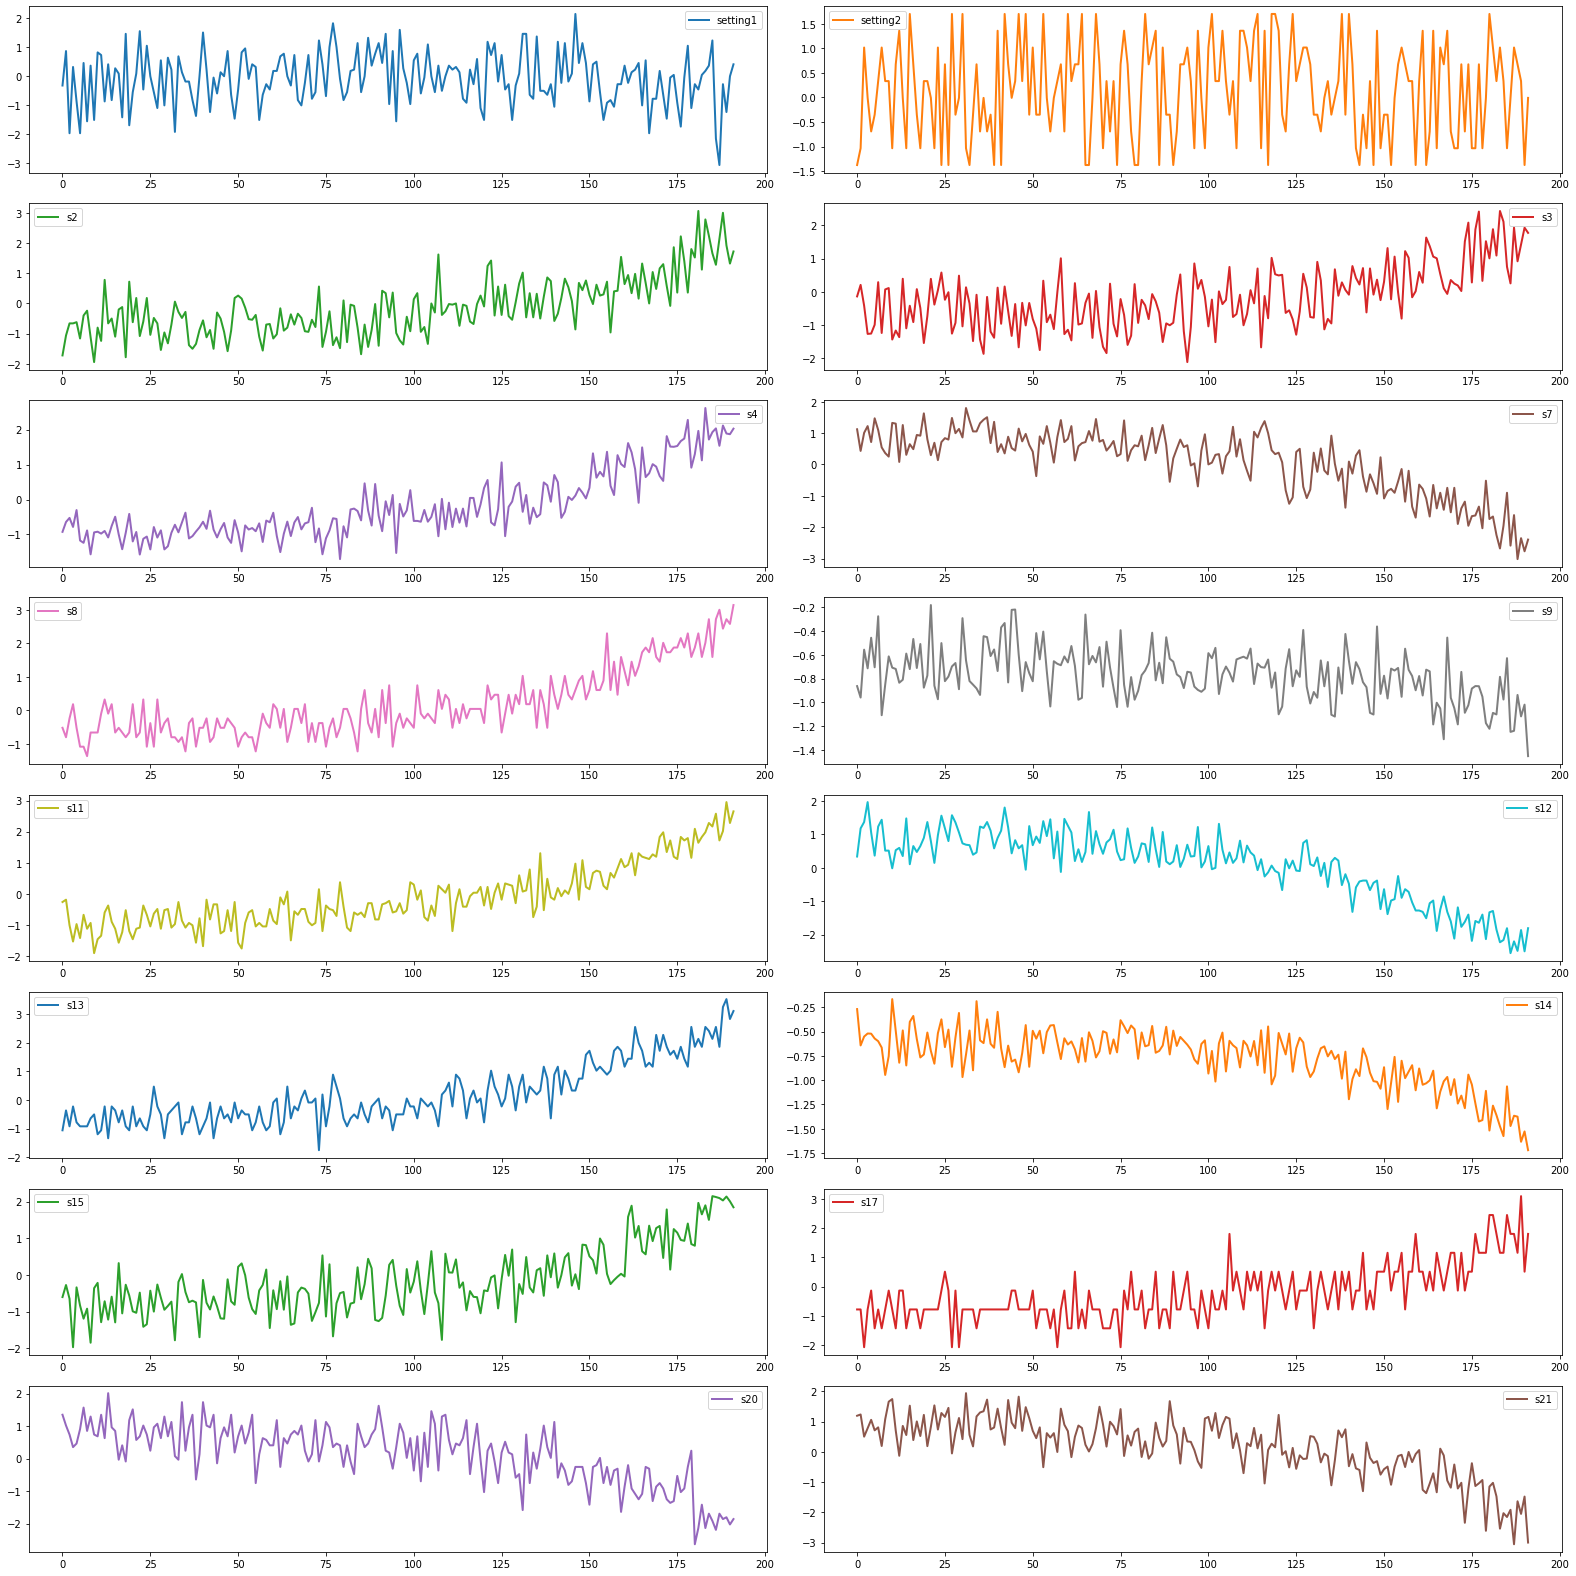

In [15]:
df[df.id==1][params].plot(subplots=True,
        layout=(8, 2),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False)

plt.tight_layout()
plt.savefig('pics/orig1.png')
plt.show()

Генерация последовательностей с окном 50

In [92]:
def seq_generator(data, seq_len, seq_cols):
    
    dt = data[seq_cols].values
    num_elem = dt.shape[0]
    for start, stop in zip(range(0, num_elem-seq_len), range(seq_len, num_elem)):
        yield df[start:stop, :]
        
def gen_labels(data, seq_len, label):
    
    dt = data[seq_cols].values
    num_elem = dt.shape[0]
    return dt[seq_len:num_elem, :]


In [93]:
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [94]:
xtrain, xtest = [], []

seq_len = 50

for eid in df.id.unique():
    for seq in gen_sequence(df[df.id==eid], seq_len, params):
        xtrain.append(seq)
    for seq in gen_sequence(test[test.id==eid], seq_len, params):
        xtest.append(seq)
        
xtrain = np.asarray(xtrain)
xtest = np.asarray(xtest)

print('Xtrain shape: {},\nXtest shape: {}'.format(xtrain.shape, xtest.shape))

Xtrain shape: (15631, 50, 16),
Xtest shape: (8162, 50, 16)


In [103]:
ytrain, ytest = [],[]

for eid in df.id.unique():
    for label in gen_labels(df[df.id==eid], seq_len, ['label']):
        ytrain.append(label)
    for label in gen_labels(test[test.id==eid], seq_len, ['label']):
        ytest.append(label)
        
ytrain = np.asarray(ytrain).reshape(-1,1)
ytest = np.asarray(ytest).reshape(-1,1)

print('Ytrain shape: {},\nYtest shape: {}'.format(ytrain.shape, ytest.shape))

Ytrain shape: (15631, 1),
Ytest shape: (8162, 1)


In [104]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)


print('Ytrain shape: {},\nYtest shape: {}'.format(ytrain.shape, ytest.shape))

Ytrain shape: (15631, 3),
Ytest shape: (8162, 3)


In [97]:
np.save('data/xtrain.npy', xtrain)
np.save('data/xtest.npy', xtest)

In [105]:
np.save('data/ytrain.npy', ytrain)
np.save('data/ytest.npy', ytest)

#### Рекуррентные графики

In [21]:
def recurrent_plots(series, eps=0.1, steps=10):
    dists = pdist(series[:,None])
    dists = np.floor(dists/eps)
    
    dists[dists > steps] = steps
    pic = squareform(dists)
    return pic

Визуализируем пример

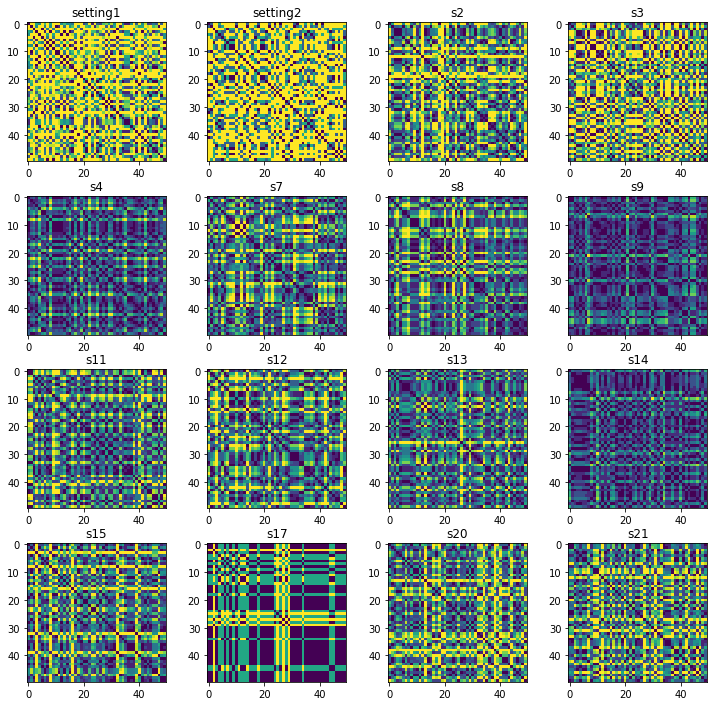

In [39]:
plt.figure(figsize=(10,10))

for i in range(len(params)):

    plt.subplot(4,4,i+1)
    rec = recurrent_plots(xtrain[0,:,i])
    
    plt.imshow(rec)
    plt.title(params[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.savefig('pics/rec_plot/0.png')
plt.show()

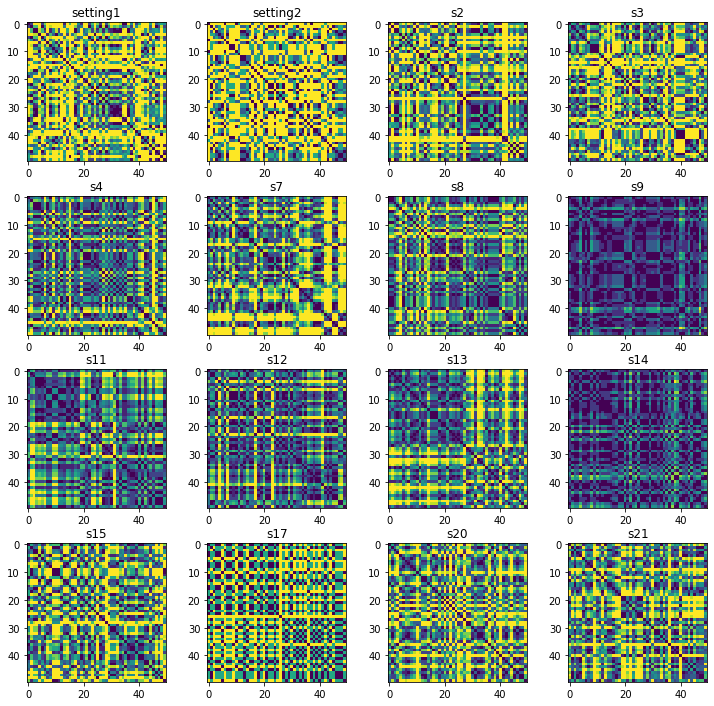

In [38]:
plt.figure(figsize=(10,10))

for i in range(len(params)):

    plt.subplot(4,4,i+1)
    rec = recurrent_plots(xtrain[80,:,i])
    
    plt.imshow(rec)
    plt.title(params[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.savefig('pics/rec_plot/80.png')
plt.show()

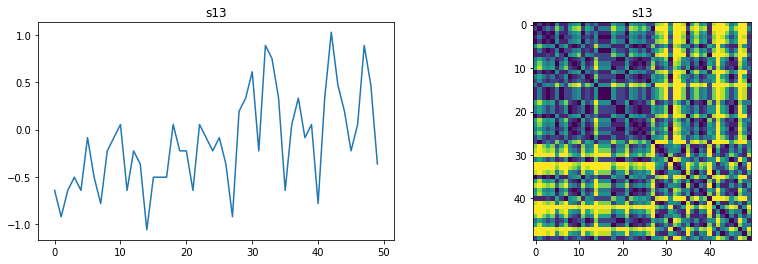

In [43]:
plt.figure(figsize=(14,4))
    
plt.subplot(1,2,1)
plt.plot(xtrain[80,:,10])
plt.title(params[10])

plt.subplot(1,2,2)
rec = recurrent_plots(xtrain[80,:,10])
plt.imshow(rec)
plt.title(params[10])

plt.savefig('pics/rec_plot/s13.png')
plt.show()

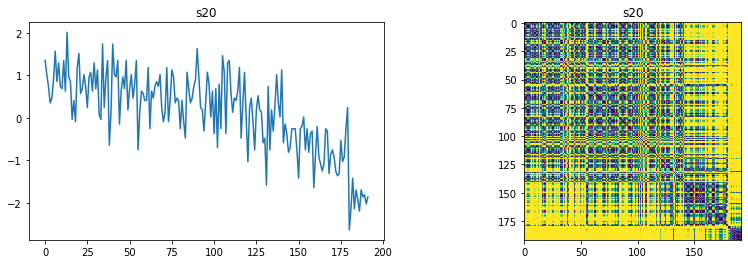

In [44]:
plt.figure(figsize=(14,4))
    
plt.subplot(1,2,1)
plt.plot(df[df.id==1]['s20'])
plt.title(params[14])

plt.subplot(1,2,2)
rec = recurrent_plots(df[df.id==1]['s20'].values)
plt.imshow(rec)
plt.title(params[14])

plt.savefig('pics/rec_plot/s20.png')
plt.show()

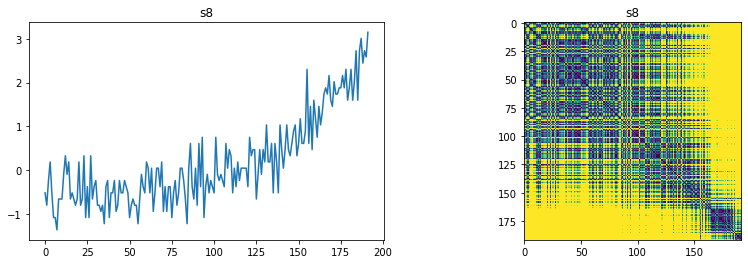

In [45]:
plt.figure(figsize=(14,4))
    
plt.subplot(1,2,1)
plt.plot(df[df.id==1]['s8'])
plt.title(params[6])

plt.subplot(1,2,2)
rec = recurrent_plots(df[df.id==1]['s8'].values)
plt.imshow(rec)
plt.title(params[6])

plt.savefig('pics/rec_plot/s8.png')
plt.show()

In [46]:
xtrain_img = np.apply_along_axis(recurrent_plots, 1, xtrain).astype('float32')
xtest_img = np.apply_along_axis(recurrent_plots, 1, xtest).astype('float32')

print(xtrain_img.shape, xtest_img.shape)

(15631, 50, 50, 16) (8162, 50, 50, 16)


In [47]:
np.save('data/xtrain_img_rec.npy', xtrain_img)
np.save('data/xtest_img_rec.npy', xtest_img)

#### Gramian Angular Field

In [50]:
def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

def cos_sum(a, b):
    return(math.cos(a+b))

In [51]:
class GAF:

    def __init__(self):
        pass
    def transform(self, serie):
        
        min_ = np.amin(serie)
        max_ = np.amax(serie)
        scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

        
        serie = np.where(serie >= 1., 1., serie)
        serie = np.where(serie <= -1., -1., serie)

        # полярные координаты
        phi = np.arccos(serie)
        r = np.linspace(0, 1, len(serie))

        # GAF Computation 
        gaf = tabulate(phi, phi, cos_sum)

        #return(gaf, phi, r, scaled_serie)
        return gaf

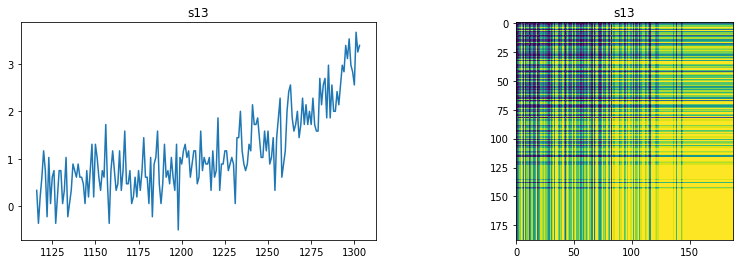

In [54]:
gaf = GAF()
plt.figure(figsize=(14,4))
    
plt.subplot(1,2,1)
plt.plot(df[df.id==6]['s13'])
plt.title('s13')

plt.subplot(1,2,2)
rec = gaf.transform(df[df.id==6]['s13'].values)
plt.imshow(rec)
plt.title('s13')

plt.savefig('pics/gaf_plot/s13.png')
plt.show()

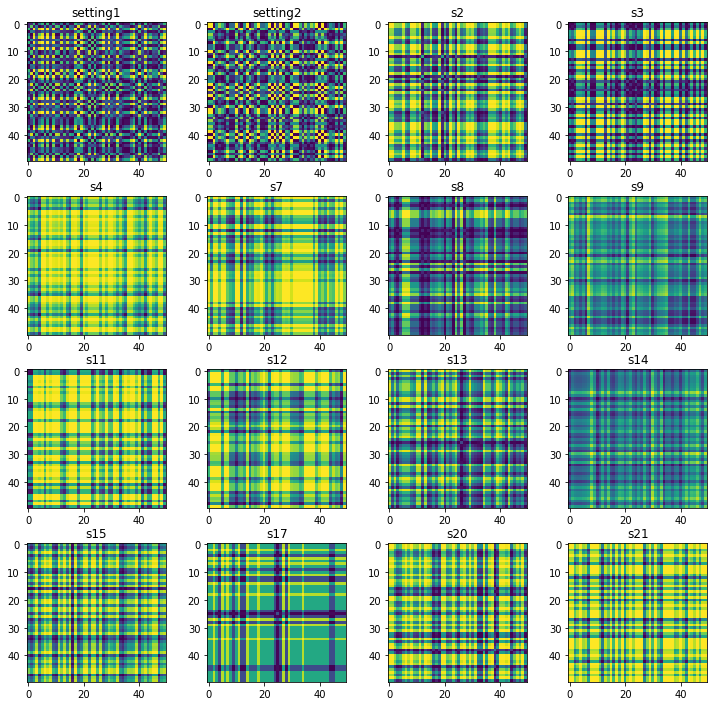

In [58]:
plt.figure(figsize=(10,10))

for i in range(len(params)):

    plt.subplot(4,4,i+1)
    rec = gaf.transform(xtrain[0,:,i])
    
    plt.imshow(rec)
    plt.title(params[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.savefig('pics/gaf_plot/0.png')
plt.show()

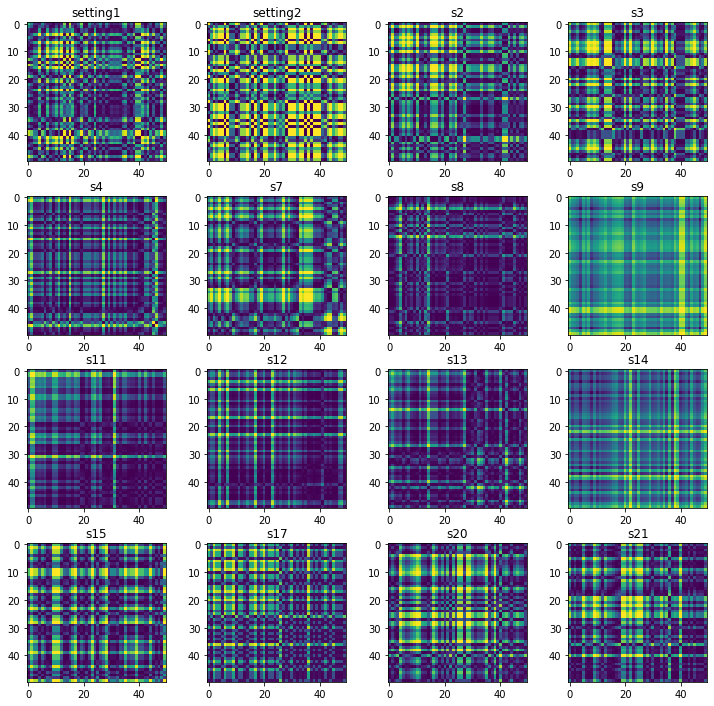

In [57]:
plt.figure(figsize=(10,10))

for i in range(len(params)):

    plt.subplot(4,4,i+1)
    rec = gaf.transform(xtrain[80,:,i])
    
    plt.imshow(rec)
    plt.title(params[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.savefig('pics/gaf_plot/80.png')
plt.show()

In [67]:
xtrain_img = np.apply_along_axis(gaf.transform, 1, xtrain).astype('float32')
xtest_img = np.apply_along_axis(gaf.transform, 1, xtest).astype('float32')

print(xtrain_img.shape, xtest_img.shape)

(15631, 50, 50, 16) (8162, 50, 50, 16)


In [69]:
np.save('data/xtrain_img_gaf.npy', xtrain_img)
np.save('data/xtest_img_gaf.npy', xtest_img)

#### 2. Отбор признаков

Для классификации

In [75]:
model = RandomForestClassifier(n_estimators=150, 
                               max_depth=8,
                               n_jobs=4)

model.fit(df_feat.drop(['label', 'RUL', 'cycle'], axis=1), df_feat.label)

model.feature_importances_

array([4.38894365e-05, 2.78316247e-03, 2.22287793e-03, ...,
       0.00000000e+00, 3.07726005e-05, 2.59550459e-04])

In [76]:
feat_imp = pd.DataFrame({'feature':df_feat.drop(['label', 'RUL', 'cycle'], axis=1).columns,
                         'importance': model.feature_importances_}).sort_values(['importance'],ascending=False)[:200]

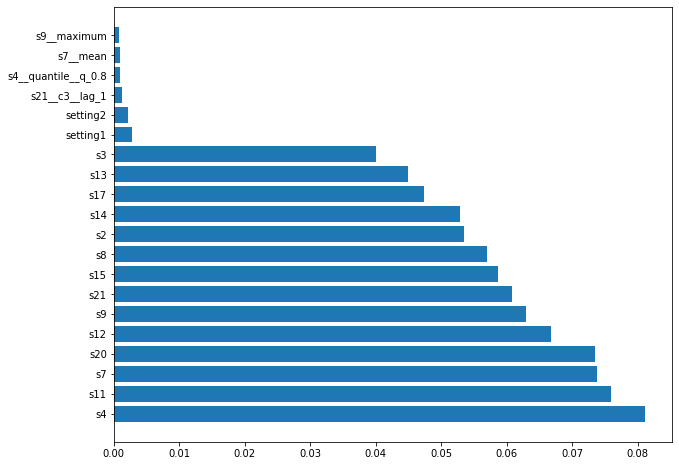

In [78]:
plt.figure(figsize=(10,8))
plt.barh(feat_imp.feature[:20], feat_imp.importance[:20])
plt.show()

In [79]:
feat_imp.to_parquet('data/feature_imp_class.parquet')

Для регрессии

In [80]:
model = RandomForestRegressor(n_estimators=150, 
                              max_depth=8,
                               n_jobs=4)

model.fit(df_feat.drop(['label', 'RUL', 'cycle'], axis=1), df_feat.RUL)

model.feature_importances_

array([4.00514627e-06, 1.68027257e-04, 8.64934630e-05, ...,
       0.00000000e+00, 0.00000000e+00, 2.08365107e-06])

In [81]:
feat_imp_reg = pd.DataFrame({'feature':df_feat.drop(['label', 'RUL', 'cycle'], axis=1).columns,
                         'importance': model.feature_importances_}).sort_values(['importance'],ascending=False)[:200]

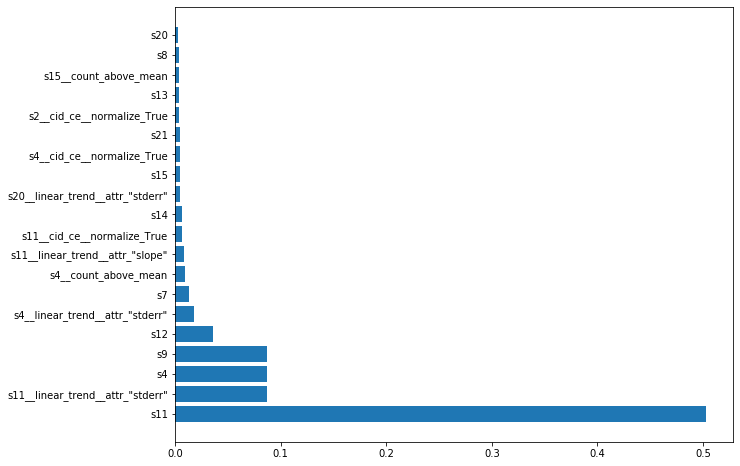

In [82]:
plt.figure(figsize=(10,8))
plt.barh(feat_imp_reg.feature[:20], feat_imp_reg.importance[:20])
plt.show()

In [83]:
feat_imp_reg.to_parquet('data/feature_imp_reg.parquet')

In [86]:
xtrain_feat, xtest_feat = [], []

seq_len = 50

for eid in df_feat.id.unique():
    for seq in gen_sequence(df_feat[df_feat.id==eid], seq_len, feat_imp.feature[:50]):
        xtrain_feat.append(seq)
    for seq in gen_sequence(test_feat[test_feat.id==eid], seq_len, feat_imp.feature[:50]):
        xtest_feat.append(seq)
        
xtrain_feat = np.asarray(xtrain_feat)
xtest_feat = np.asarray(xtest_feat)

print('Xtrain shape: {},\nXtest shape: {}'.format(xtrain_feat.shape, xtest_feat.shape))

Xtrain shape: (15631, 50, 50),
Xtest shape: (8162, 50, 50)


In [87]:
np.save('data/xtrain_feat.npy', xtrain_feat)
np.save('data/xtest_feat.npy', xtest_feat)